In [1]:
import os
import pickle
from metient.util import plotting_util as plutil
from metient.util.globals import *

REPO_DIR = os.path.join(os.getcwd(), "../../")


/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


CUDA GPU: False


In [2]:
PARAMS = "03282024_U_cutoff_0.1"
METIENT_OUTPUT_DIR = os.path.join(REPO_DIR, 'metient/data/tracerx_nsclc/metient_outputs')
ORCHARD_OUTPUT_DIR = os.path.join(METIENT_OUTPUT_DIR, 'pyclone_clustered_orchard_trees')
CONIPHER_OUTPUT_DIR = os.path.join(METIENT_OUTPUT_DIR, f'pyclone_clustered_conipher_trees_{PARAMS}')
TRACERX_DATA_DIR = os.path.join(REPO_DIR, "metient/data/tracerx_nsclc/")


MONO_COLOR = "#6aa84fff"
POLY_COLOR = "#2496c8ff"

MAX_K = float("inf") # Pareto front anyways

In [3]:
import gzip
import torch

def get_patients(pickle_files_dir):
    patients = set()
    for file in os.listdir(pickle_files_dir):
        if ".pkl.gz" in file:
            name = file.split(".")[0].replace("_calibrate", "")
            patients.add(name)
    return patients

def patient_in_dict(dct, patient):
    for patient_primary in dct:
        if patient == patient_primary.split("_")[0]:
            return True, patient_primary, dct[patient_primary]
    return False, None, None

def is_better_pattern(old_patterns, new_patterns):
    for new_pattern in new_patterns:
        if "monoclonal" in new_pattern or "monophyletic" in new_pattern:
            return True
    return False


def get_info(pickle_files_dir):
    patients = get_patients(pickle_files_dir)
    seeding_patterns = dict()
    for patient in patients:
        with gzip.open(os.path.join(pickle_files_dir, f"{patient}.pkl.gz"),'rb') as f:
            pckl = pickle.load(f)
        Vs = pckl[OUT_LABElING_KEY]
        As = pckl[OUT_ADJ_KEY]
        idx_to_labels = pckl[OUT_IDX_LABEL_KEY]
        loss_dicts = pckl[OUT_LOSS_DICT_KEY]
        sites = pckl[OUT_SITES_KEY]
        primary_label =  "_".join(patient.split("_")[1:])
        tracerx_patterns = []
        patterns = []
        Gs = []
        gen_dist_losses = []
        
        for x, (V, A, idx_to_label, loss_dict) in enumerate(zip(Vs, As, idx_to_labels, loss_dicts)):
            if x > MAX_K:
                continue
            V = torch.tensor(V)
            A = torch.tensor(A)
            tracerx_pattern = plutil.get_tracerx_seeding_pattern(V, A, sites, primary_label,idx_to_label)
            pattern = plutil.get_verbose_seeding_pattern(V, A)
            G = plutil.get_migration_graph(V,A)
            #print(x, tracerx_pattern)
            tracerx_patterns.append(tracerx_pattern)
            patterns.append(pattern)
            Gs.append(G)
            gen_dist_losses.append(float(loss_dict[GEN_DIST_KEY]))
        # For patients with multiple primaries
        patient_name = patient.split("_")[0]
        if patient_name in seeding_patterns:
            prev_tracerx_pattern = seeding_patterns[patient_name][1]
            # choose the run with the primary that was more parsimonious
            if is_better_pattern(prev_tracerx_pattern, tracerx_pattern):
                seeding_patterns[patient_name] = patterns, tracerx_patterns, Gs, gen_dist_losses
        else:
            seeding_patterns[patient_name] = patterns, tracerx_patterns, Gs, gen_dist_losses

    print(f"{len(seeding_patterns)} patients")
    return seeding_patterns

### Load metient outputs using various combinations of clustering alg + tree inference alg + metient hyperparams

In [4]:
# (1) pyclone clusters + conipher trees + metient (maximum parsimony)
# conipher_mp_patterns, _ = get_info(os.path.join(CONIPHER_OUTPUT_DIR, 'max_pars'))

# (2) pyclone clusters + conipher trees + metient (maximum parsimony + genetic distance)
conipher_mp_gd_seeding_patterns = get_info(os.path.join(CONIPHER_OUTPUT_DIR, 'calibrate'))

# (3) pyclone clusters + orchard trees + metient (maximum parsimony)
# orchard_mp_seeding_patterns, _ = get_info(os.path.join(ORCHARD_OUTPUT_DIR, 'max_pars'))

# (4) pyclone clusters + orchard trees + metient (maximum parsimony + genetic distance)
# orchard_mp_gd_seeding_patterns, _ = get_info(os.path.join(ORCHARD_OUTPUT_DIR, 'max_pars_genetic_distance'))

inferred_patterns = conipher_mp_gd_seeding_patterns


123 patients


In [5]:
inferred_patterns

{'CRUK0514': (['polyclonal primary single-source seeding'],
  ['monoclonal monophyletic'],
  [tensor([[0., 0.],
           [2., 0.]])],
  [3.4494900703430176]),
 'CRUK0636': (['polyclonal primary single-source seeding',
   'polyclonal primary single-source seeding'],
  ['polyclonal monophyletic', 'polyclonal monophyletic'],
  [tensor([[0., 0.],
           [2., 0.]]),
   tensor([[0., 0.],
           [2., 0.]])],
  [3.24745512008667, 3.381587028503418]),
 'CRUK0598': (['polyclonal primary single-source seeding',
   'polyclonal primary single-source seeding',
   'polyclonal primary single-source seeding'],
  ['monoclonal monophyletic',
   'polyclonal monophyletic',
   'polyclonal monophyletic'],
  [tensor([[0., 0.],
           [2., 0.]]),
   tensor([[0., 0.],
           [2., 0.]]),
   tensor([[0., 0.],
           [2., 0.]])],
  [2.8751986026763916, 3.0517454147338867, 4.078981876373291]),
 'CRUK0337': (['polyclonal primary single-source seeding',
   'polyclonal primary single-source seedi

### How many patients have different migration graphs in their top 5 solutions

In [6]:
mult_mig_graphs = set()
for patient in inferred_patterns:
    Gs = inferred_patterns[patient][2]
    gen_dist_losses = inferred_patterns[patient][3]
    if len(Gs) == 1: continue
    fG = Gs[0]
    fgpattern = plutil.get_seeding_pattern_with_G(fG)
    fgd = gen_dist_losses[0]
    for G,gd_loss in zip(Gs[1:], gen_dist_losses[1:]):
        pattern = plutil.get_seeding_pattern_with_G(G)
        if not torch.equal(G ,fG) and round(gd_loss,3) != round(fgd,3) and pattern==fgpattern:
            mult_mig_graphs.add(patient)
mult_mig_graphs

{'CRUK0256', 'CRUK0587'}

### Get sample info

In [7]:
import pandas as pd
sample_info_df= pd.read_csv(os.path.join(TRACERX_DATA_DIR,"sample_overview_original.txt"), sep="\t")
print(sample_info_df.head())


  patient_id tumour_id             region  sampleType sampleTypeDetail
0   CRUK0010  CRUK0010  CRUK0010_SU_T1.R1     primary          primary
1   CRUK0010  CRUK0010  CRUK0010_SU_T1.R2     primary          primary
2   CRUK0010  CRUK0010   CRUK0010_SU_FLN1  metastasis               LN
3   CRUK0010  CRUK0010    CRUK0010_BR_LN1  metastasis  metachronousMet
4   CRUK0010  CRUK0010    CRUK0010_BR_LN2  metastasis  metachronousMet


### How often are samples monoclonal vs. polyclonal?

{'mono_poly': ['monoclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'monoclonal', 'monoclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'monoclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'polyclonal', 'poly

/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 75.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 48.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

monoclonal v.s. polyclonal: Welch's t-test independent samples, P_val=1.779e-10 stat=-7.268e+00


<Figure size 640x480 with 0 Axes>

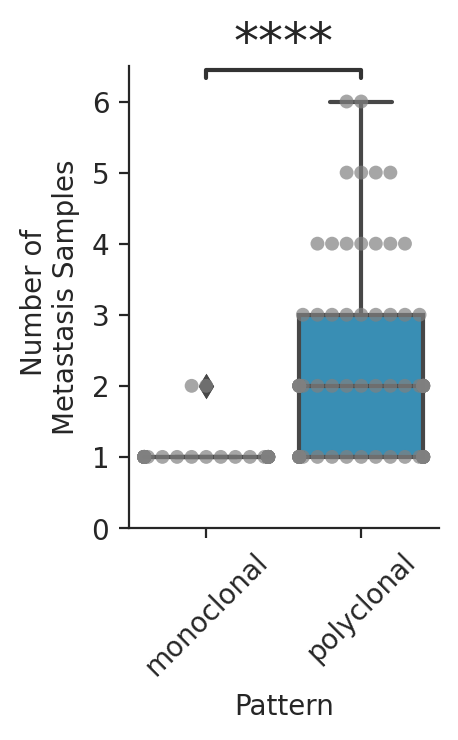

In [8]:
def get_num_met_samples(patient_id):
    sample_types = sample_info_df[sample_info_df['patient_id']==patient_id]['sampleType']
    return sample_types.value_counts()['metastasis']
    
mono_poly_data = {"mono_poly" : [], "num_samples" : [], "patient":[]}
for key, (patterns, tracerx_patterns, _, _) in inferred_patterns.items():
    patient = key.split("_")[0]
    pattern = patterns[0]
    tracerx_pattern = tracerx_patterns[0]
    # TODO: investigate these no seeding cases
    if (pattern.split()[0]=="no"):
        continue
    mono_poly_data['patient'].append(patient)
    mono_poly_data["mono_poly"].append(tracerx_pattern.split()[0])
    mono_poly_data["num_samples"].append(get_num_met_samples(patient))
print(mono_poly_data)
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()
fig = plt.figure(figsize=(2, 3), dpi=200)
palette = {"monoclonal":MONO_COLOR, "polyclonal":POLY_COLOR}
snsfig = sns.boxplot(x='mono_poly', y='num_samples', data=mono_poly_data, order=["monoclonal", "polyclonal"], linewidth=1.5, palette=palette, showfliers=True)
sns.swarmplot(x='mono_poly', y='num_samples', data=mono_poly_data, color="grey", dodge=False, alpha=0.7)  # Scatter plot
add_stat_annotation(snsfig, data=mono_poly_data, x='mono_poly', y='num_samples',
                    box_pairs=[("monoclonal", "polyclonal")], test='t-test_welch', text_format='star', loc='inside', verbose=1, fontsize=18, comparisons_correction=None)
plt.ylim(0, 6.5) 
plt.xlabel("Pattern")
plt.ylabel("Number of \nMetastasis Samples")
plt.xticks(rotation=45)
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)
fig.savefig(os.path.join(REPO_DIR, "metient/test/output_plots/tracerx", f"mono_vs_poly_num_samples_weight_exploration_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 

<Figure size 640x480 with 0 Axes>

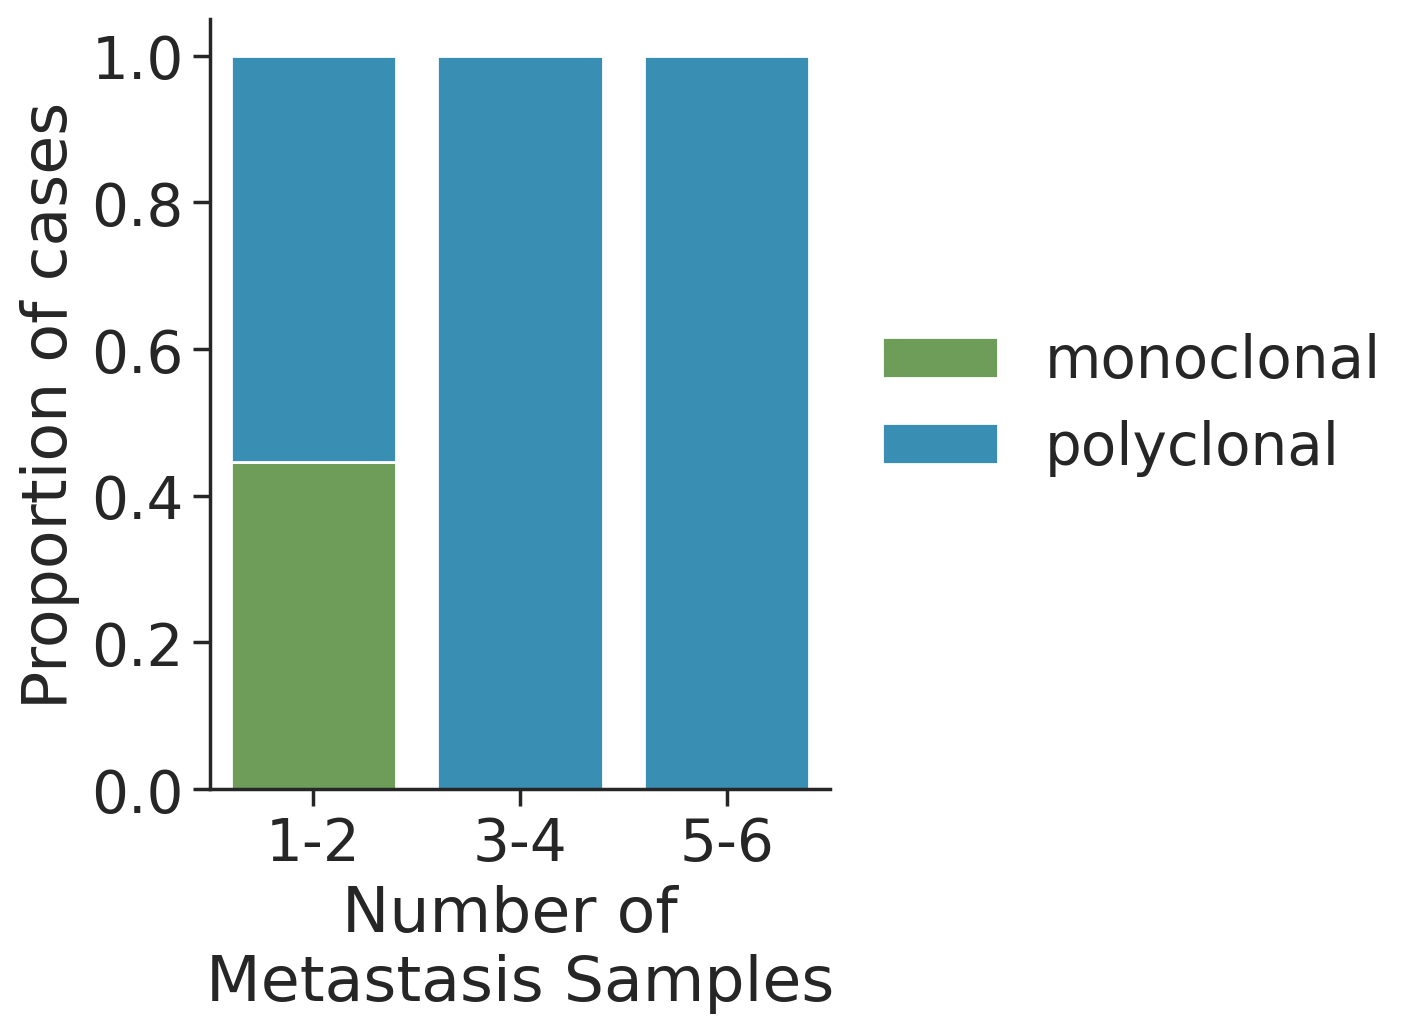

In [9]:
sns.set(font_scale=1.9)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()
fig = plt.figure(figsize=(4, 5), dpi=200)
palette = {"monoclonal":"#00A088", "polyclonal":"#3B5587"}

# Create a DataFrame
num_samples_df = pd.DataFrame(mono_poly_data)

# Define the num_sites ranges
num_samples_df['num_samples_range'] = pd.cut(num_samples_df['num_samples'], bins=[0, 2, 4, 6], labels=["1-2", "3-4", "5-6"])

# Calculate the proportions of monoclonal and polyclonal within each range
proportions = num_samples_df.groupby(['num_samples_range', 'mono_poly']).size().unstack(fill_value=0).div(num_samples_df.groupby('num_samples_range').size(), axis=0)

# Reset the index
proportions.reset_index(inplace=True)

# Create a stacked bar plot
ax1 = sns.barplot(x='num_samples_range', y='monoclonal', data=proportions, color=MONO_COLOR, label='monoclonal')
ax2 = sns.barplot(x='num_samples_range', y='polyclonal', data=proportions, color=POLY_COLOR, bottom=proportions['monoclonal'], label='polyclonal')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add labels and legend
plt.xlabel("Number of \nMetastasis Samples")
plt.ylabel("Proportion of cases")
plt.title("")
plt.legend(title="",  loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)

# Show the plot
plt.show()
fig.savefig(os.path.join(REPO_DIR, "metient/test/output_plots/tracerx", f"mono_vs_poly_prop_num_samples_weight_exploration_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 

In [10]:
num_samples_df[["mono_poly", "num_samples_range"]].value_counts()

mono_poly   num_samples_range
polyclonal  1-2                  56
monoclonal  1-2                  45
polyclonal  3-4                  16
            5-6                   6
dtype: int64

In [11]:
def get_source(p):
    '''
    {primary single-source, single-source, multi-source, reseeding, no seeding} 
    '''
    items = p.split()
    if len(items) == 4:
        return " ".join(items[1:3])
    if items == ["no", "seeding"]:
        return " ".join(items)
    return items[1]

### How concordant are our seeding patterns with TRACERx's?

In [12]:
tracerx_seeding = pd.read_csv(os.path.join(TRACERX_DATA_DIR, "seedingTable.txt"), sep="\t")
tracerx_seeding.columns = ["patient_id", "tracerx_clonality","tracerx_phyletic", "tracerx_multitree_adjustment"] 
print(len(tracerx_seeding))
from collections import OrderedDict

def get_metient_patterns(row, pattern_idx, is_phyletic):
    patient_id = row['patient_id'].split("_")[0]
    if patient_id not in inferred_patterns:
        print(patient_id)
        return "  "
    # make unique while preserving order
    patterns = list(OrderedDict.fromkeys(inferred_patterns[patient_id][pattern_idx]))
    if "no seeding" in patterns:
        print("no seeding", patient_id)
        return "  "
    clonalities = [pattern.split()[0] for pattern in patterns]
    if is_phyletic:
        sources_phyletics = [pattern.split()[1] for pattern in patterns]
    else:
        sources_phyletics = [get_source(pattern) for pattern in patterns]

    return ",".join(clonalities), ",".join(sources_phyletics)

tracerx_seeding['metient_tracerx_clonalities'] = tracerx_seeding.apply(lambda row: get_metient_patterns(row, 1, True)[0], axis=1)
tracerx_seeding['metient_tracerx_phyletics'] = tracerx_seeding.apply(lambda row: get_metient_patterns(row, 1, True)[1], axis=1)

tracerx_seeding['metient_clonalities'] = tracerx_seeding.apply(lambda row: get_metient_patterns(row, 0, False)[0], axis=1)
tracerx_seeding['metient_sources'] = tracerx_seeding.apply(lambda row: get_metient_patterns(row, 0, False)[1], axis=1)
tracerx_seeding

126
CRUK0412
CRUK0730
CRUK0666
CRUK0412
CRUK0730
CRUK0666
CRUK0412
CRUK0730
CRUK0666
CRUK0412
CRUK0730
CRUK0666


,patient_id,tracerx_clonality,tracerx_phyletic,tracerx_multitree_adjustment,metient_tracerx_clonalities,metient_tracerx_phyletics,metient_clonalities,metient_sources
0,CRUK0010,monoclonal,monophyletic,monophyletic,polyclonal,monophyletic,"polyclonal,polyclonal","primary single-source,multi-source"
1,CRUK0013,monoclonal,monophyletic,monophyletic,polyclonal,monophyletic,polyclonal,primary single-source
2,CRUK0284,monoclonal,monophyletic,monophyletic,polyclonal,monophyletic,"polyclonal,polyclonal","primary single-source,multi-source"
3,CRUK0361,monoclonal,monophyletic,monophyletic,"polyclonal,monoclonal","monophyletic,monophyletic",polyclonal,primary single-source
4,CRUK0497,monoclonal,monophyletic,monophyletic,monoclonal,monophyletic,polyclonal,primary single-source
...,...,...,...,...,...,...,...,...
121,CRUK0495,polyclonal,monophyletic,monophyletic,"monoclonal,polyclonal","monophyletic,monophyletic",polyclonal,primary single-source
122,CRUK0476,monoclonal,monophyletic,monophyletic,"monoclonal,polyclonal","monophyletic,monophyletic",polyclonal,primary single-source
123,CRUK0528,polyclonal,polyphyletic,polyphyletic,"monoclonal,polyclonal","monophyletic,monophyletic",polyclonal,primary single-source
124,CRUK0666,polyclonal,polyphyletic,polyphyletic,,,,


In [13]:
tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']=="monophyletic")&(tracerx_seeding['metient_tracerx_phyletics']=="polyphyletic")]
# tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']=="polyphyletic")]



,patient_id,tracerx_clonality,tracerx_phyletic,tracerx_multitree_adjustment,metient_tracerx_clonalities,metient_tracerx_phyletics,metient_clonalities,metient_sources
86,CRUK0029,polyclonal,monophyletic,monophyletic,polyclonal,polyphyletic,polyclonal,primary single-source
99,CRUK0584,monoclonal,monophyletic,monophyletic,polyclonal,polyphyletic,polyclonal,primary single-source


In [14]:
tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']=="polyphyletic")&(tracerx_seeding['metient_tracerx_phyletics'].str.contains("monophyletic"))]
                

,patient_id,tracerx_clonality,tracerx_phyletic,tracerx_multitree_adjustment,metient_tracerx_clonalities,metient_tracerx_phyletics,metient_clonalities,metient_sources
7,CRUK0484,polyclonal,polyphyletic,polyphyletic,polyclonal,monophyletic,"polyclonal,polyclonal","multi-source,primary single-source"
8,CRUK0418,polyclonal,polyphyletic,polyphyletic,"polyclonal,monoclonal","monophyletic,monophyletic",polyclonal,primary single-source
13,CRUK0027,polyclonal,polyphyletic,polyphyletic,polyclonal,monophyletic,polyclonal,primary single-source
19,CRUK0178,polyclonal,polyphyletic,polyphyletic,polyclonal,monophyletic,polyclonal,primary single-source
32,CRUK0543,polyclonal,polyphyletic,polyphyletic,polyclonal,monophyletic,polyclonal,primary single-source
42,CRUK0799,polyclonal,polyphyletic,polyphyletic,polyclonal,monophyletic,polyclonal,primary single-source
54,CRUK0415,polyclonal,polyphyletic,polyphyletic,polyclonal,monophyletic,polyclonal,primary single-source
68,CRUK0311,polyclonal,polyphyletic,polyphyletic,polyclonal,monophyletic,polyclonal,primary single-source
81,CRUK0510,polyclonal,polyphyletic,polyphyletic,polyclonal,monophyletic,polyclonal,primary single-source
84,CRUK0063,polyclonal,polyphyletic,polyphyletic,"polyclonal,polyclonal","monophyletic,polyphyletic",polyclonal,primary single-source


In [15]:
set(tracerx_seeding['patient_id']) - set(inferred_patterns.keys())

{'CRUK0084_Tumour2',
 'CRUK0301_Tumour1',
 'CRUK0372_Tumour1',
 'CRUK0412',
 'CRUK0620_Tumour1',
 'CRUK0666',
 'CRUK0721_Tumour1',
 'CRUK0730'}

In [16]:
inferred_patterns['CRUK0721']

(['polyclonal primary single-source seeding',
  'polyclonal primary single-source seeding'],
 ['polyclonal monophyletic', 'polyclonal monophyletic'],
 [tensor([[0., 0.],
          [3., 0.]]),
  tensor([[0., 0.],
          [3., 0.]])],
 [3.798471689224243, 3.931441068649292])

### How concordant are our characterizations of monoclonal/polyclonal with TRACERx

tracerx mono met mono 11
tracerx mono met poly 76
tracerx poly met poly 39
1
tracerx poly met mono 1
                                       Method  Number of cases
0                                  Monoclonal               11
1                                  Polyclonal               39
2  Metient: Polyclonal, \nTRACERx: Monoclonal               76
3  Metient: Monoclonal, \nTRACERx: Polyclonal                1


<Figure size 640x480 with 0 Axes>

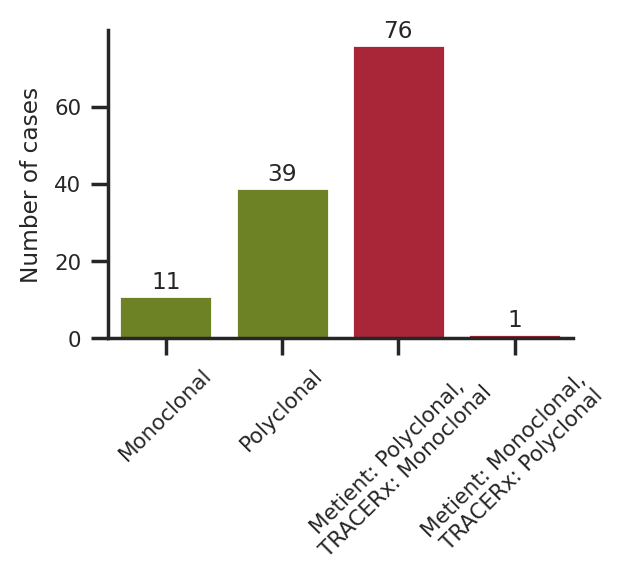

In [17]:

num_tracerx_mono_met_mono = len(tracerx_seeding[(tracerx_seeding['tracerx_clonality']=="monoclonal")&(tracerx_seeding['metient_clonalities'].str.contains("monoclonal"))])
print("tracerx mono met mono", (num_tracerx_mono_met_mono))
num_tracerx_mono_met_poly = len(tracerx_seeding[(tracerx_seeding['tracerx_clonality']=="monoclonal")&(tracerx_seeding['metient_clonalities'].str.contains("polyclonal"))])
print("tracerx mono met poly", (num_tracerx_mono_met_poly))
num_tracerx_poly_met_poly = len(tracerx_seeding[(tracerx_seeding['tracerx_clonality']=="polyclonal")&(tracerx_seeding['metient_clonalities'].str.contains("polyclonal"))])
print("tracerx poly met poly", (num_tracerx_poly_met_poly))
num_tracerx_poly_met_mono = len(tracerx_seeding[(tracerx_seeding['tracerx_clonality']=="polyclonal")&(tracerx_seeding['metient_clonalities'].str.contains("monoclonal"))])
print(num_tracerx_poly_met_mono)
print("tracerx poly met mono", (num_tracerx_poly_met_mono))


data = [["Monoclonal", num_tracerx_mono_met_mono], 
        ["Polyclonal",num_tracerx_poly_met_poly], 
        ["Metient: Polyclonal, \nTRACERx: Monoclonal",num_tracerx_mono_met_poly],
        ["Metient: Monoclonal, \nTRACERx: Polyclonal",num_tracerx_poly_met_mono],]
df = pd.DataFrame( data,columns=["Method", "Number of cases"])
print(df)
sns.set(font_scale=0.7)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()
fig = plt.figure(figsize=(3, 2), dpi=200)
sns.set_palette(sns.color_palette(["#759116", "#759116", "#bf1029", "#bf1029"]))
ax = sns.barplot(data=df, x="Method", y="Number of cases", hue="Method",dodge=False)
ax.legend().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), 
                textcoords='offset points')
# Add labels and legend
plt.xlabel("")
plt.ylabel("Number of cases")
plt.xticks(rotation=45)
fig.savefig(os.path.join(REPO_DIR, "metient/test/output_plots/tracerx", f"clonality_consensus_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 


### How concordant are our characterizations of monophyletic/polyphyletic with TRACERx

tracerx mono met mono 107
tracerx mono met poly 0
tracerx poly met poly 0
16
tracerx poly met mono 16
total 123


<Figure size 640x480 with 0 Axes>

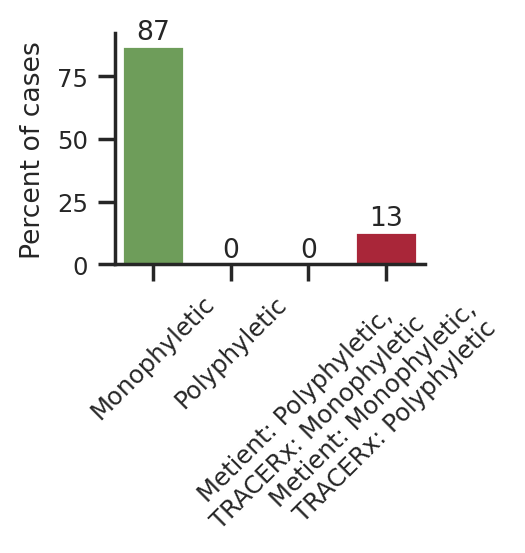

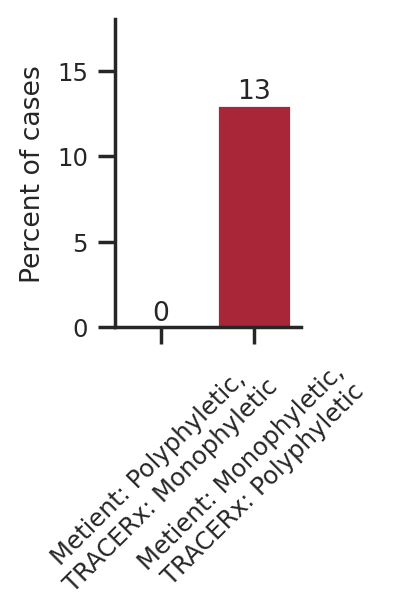

In [18]:

def phyletic_consensus(data, output_name, colors, size, rotate=45):
    df = pd.DataFrame( data,columns=["Method", "Number of cases"])
    sns.set(font_scale=0.8, font="Arial")
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    sns.despine()
    fig = plt.figure(figsize=(size[0], size[1]), dpi=200)
    sns.set_palette(sns.color_palette(colors))
    ax = sns.barplot(data=df, x="Method", y="Number of cases",  hue="Method", dodge=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend().set_visible(False)

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 5), 
                    textcoords='offset points')
    # Add labels and legend
    plt.xlabel("")
    plt.ylabel("Percent of cases")
    plt.ylim(0,max([x[1] for x in data])+5)
    plt.xticks(rotation=rotate)
    fig.savefig(os.path.join(REPO_DIR, "metient/test/output_plots/tracerx", f"phyletic_consensus_{output_name}_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 

num_tracerx_mono_met_mono = len(tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']=="monophyletic")&(tracerx_seeding['metient_tracerx_phyletics'][0]=="monophyletic")])
print("tracerx mono met mono", (num_tracerx_mono_met_mono))
num_tracerx_mono_met_poly = len(tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']=="monophyletic")&(tracerx_seeding['metient_tracerx_phyletics'][0]=="polyphyletic")])
print("tracerx mono met poly", (num_tracerx_mono_met_poly))
num_tracerx_poly_met_poly = len(tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']=="polyphyletic")&(tracerx_seeding['metient_tracerx_phyletics'][0]=="polyphyletic")])
print("tracerx poly met poly", (num_tracerx_poly_met_poly))
num_tracerx_poly_met_mono = len(tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']=="polyphyletic")&(tracerx_seeding['metient_tracerx_phyletics'][0]=="monophyletic")])
print(num_tracerx_poly_met_mono)
print("tracerx poly met mono", (num_tracerx_poly_met_mono))
total = num_tracerx_mono_met_mono+num_tracerx_mono_met_poly+num_tracerx_poly_met_poly+num_tracerx_poly_met_mono
print("total", total)
data = [["Monophyletic", 100*(num_tracerx_mono_met_mono/total)], 
        ["Polyphyletic",100*(num_tracerx_poly_met_poly/total)], 
        ["Metient: Polyphyletic, \nTRACERx: Monophyletic",100*(num_tracerx_mono_met_poly/total)],
        ["Metient: Monophyletic, \nTRACERx: Polyphyletic",100*(num_tracerx_poly_met_mono/total)],]

phyletic_consensus(data, "", ["#6aa84f", "#6aa84f", "#bf1029", "#bf1029"], (2,1.5))

# Only show disagreement
data = [["Metient: Polyphyletic, \nTRACERx: Monophyletic",100*(num_tracerx_mono_met_poly/total)],
        ["Metient: Monophyletic, \nTRACERx: Polyphyletic",100*(num_tracerx_poly_met_mono/total)],]
phyletic_consensus(data, "disagreement", ["#bf1029", "#bf1029"], (1.2,2), rotate=45)


In [19]:
tracerx_poly_met_mono = tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']=="polyphyletic")&(tracerx_seeding['metient_tracerx_phyletics'][0]=="monophyletic")]
tracerx_poly_met_mono_pids = list(tracerx_poly_met_mono['patient_id'].unique())
print(len(tracerx_poly_met_mono_pids))


from collections import Counter
num_seeding_sites = []
for pid in tracerx_poly_met_mono_pids:
    if pid in inferred_patterns:
        best_G = inferred_patterns[pid][2][0]
        non_zero_rows = torch.unique(best_G.nonzero()[:, 0])
        num_non_zero_rows = len(non_zero_rows)
        num_seeding_sites.append(num_non_zero_rows)

ctr = Counter(num_seeding_sites)
ctr
    

16


Counter({2: 2, 1: 13})

### How concordant are our characterizations of single-source/multi-source with TRACERx (which assumes primary single-source)

123
primary single-source    112
single-source              6
multi-source               5
Name: source, dtype: int64
                  Source  Counts
0  primary single-source     112
1          single-source       6
2           multi-source       5


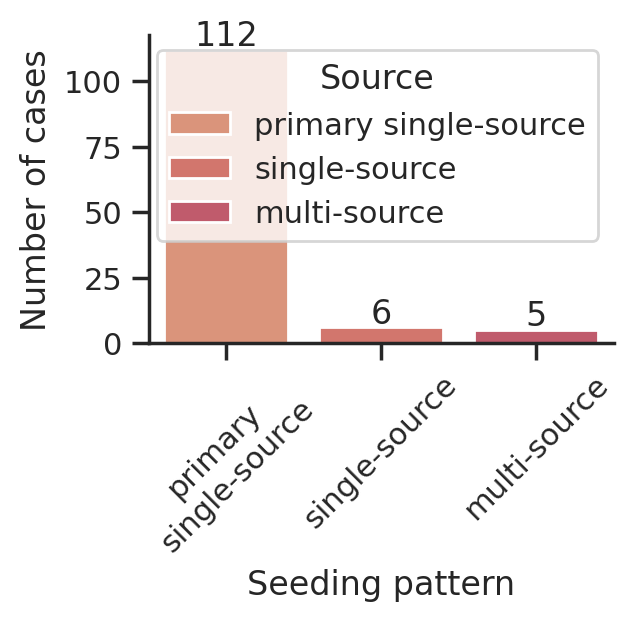

In [20]:
data = {"mono_poly" : [], "source" : [], "patient":[]}

    
for key, (patterns, tracerx_patterns, _, _) in inferred_patterns.items():
    patient = key.split("_")[0]
    pattern = patterns[0]
    data["patient"].append(patient)
    data["mono_poly"].append(pattern.split()[0])
    data["source"].append(get_source(pattern))
print(len(data["source"]))
# Create a DataFrame
top_pattern_df = pd.DataFrame(data)
print(top_pattern_df['source'].value_counts())
top_counts = top_pattern_df['source'].value_counts().reset_index()
top_counts.columns = ['Source', 'Counts']
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
sns.set_style("ticks")
#sns.set_palette(sns.color_palette(["#6aa84f", "#c27ba0", "#e69138", "#6fa8dc"]))
sns.set_palette(sns.color_palette("flare"))
print(top_counts)
custom_labels = ["\n".join(label.split()) for label in top_pattern_df['source'].value_counts().index]
fig = plt.figure(figsize=(3, 2), dpi=200)
ax = sns.barplot(data=top_counts,x='Source',y='Counts',  hue="Source", dodge=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), 
                textcoords='offset points')

    

plt.xlabel("Seeding pattern")
plt.ylabel("Number of cases")
plt.xticks(rotation=45, ticks=range(len(custom_labels)), labels=custom_labels)
plt.savefig(os.path.join(REPO_DIR, "metient/test/output_plots/tracerx", f"verbose_source_distribution_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 
plt.show()


[112, 123] [11, 0]


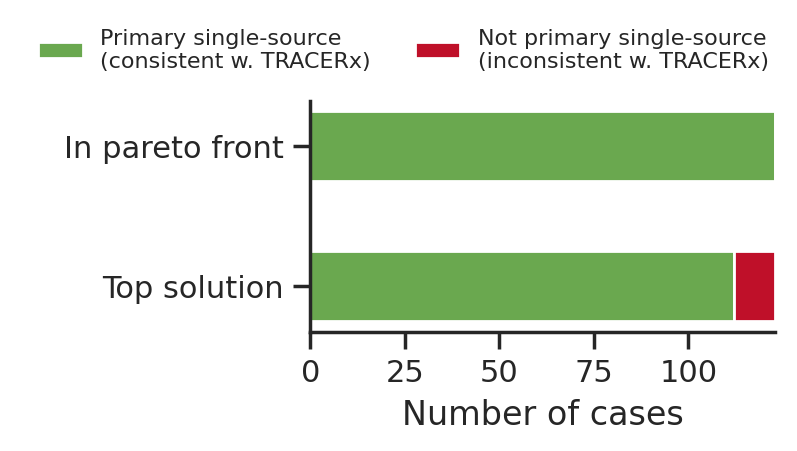

In [21]:
# Create a horizontal stacked bar chart using Seaborn

topk_prim_single_source = len(tracerx_seeding[(tracerx_seeding['metient_sources'].str.contains("primary single-source"))])

fig = plt.figure(figsize=(3, 1.5), dpi=200)
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
sns.set_style("ticks")
ax = fig.add_subplot(111)
ys = ['Top solution', f'In pareto front']
top_prim_single_source_count = top_counts[top_counts['Source']=='primary single-source']['Counts'].item()
prim_single_source_counts = [top_prim_single_source_count, topk_prim_single_source]
not_prim_single_source_counts = [len(inferred_patterns)-x for x in prim_single_source_counts]
print(prim_single_source_counts, not_prim_single_source_counts)
ax.barh(ys, prim_single_source_counts, align='center', height=.5, color='#6aa84f',label='Primary single-source\n(consistent w. TRACERx)')
ax.barh(ys, not_prim_single_source_counts, align='center', height=.5, left=prim_single_source_counts, color="#bf1029",label='Not primary single-source\n(inconsistent w. TRACERx)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.2, 1.4), frameon=False, fontsize=8)

plt.xlabel("Number of cases")
plt.ylabel("  ")
#plt.xticks(rotation=0, ticks=range(len(custom_labels)), labels=custom_labels)
plt.savefig(os.path.join(REPO_DIR, "metient/test/output_plots/tracerx", f"concordance_prim_single_source_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 
plt.show()
